In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import signal
import scipy.io as sio

from sklearn.decomposition import FastICA, PCA

In [2]:
import numpy as np
from scipy.linalg import eig, sqrtm, inv
import pdb

def cjade(X, m=None, max_iter=200):
    # Source separation of complex signals with JADE.
    # Jade performs `Source Separation' in the following sense:
    #   X is an n x T data matrix assumed modelled as X = A S + N where
    # 
    # o A is an unknown n x m matrix with full rank.
    # o S is a m x T data matrix (source signals) with the properties
    #    	a) for each t, the components of S(:,t) are statistically
    #    	   independent
    # 	b) for each p, the S[p,:] is the realization of a zero-mean
    # 	   `source signal'.
    # 	c) At most one of these processes has a vanishing 4th-order
    # 	   cumulant.
    # o  N is a n x T matrix. It is a realization of a spatially white
    #    Gaussian noise, i.e. Cov(X) = sigma*eye(n) with unknown variance
    #    sigma.  This is probably better than no modeling at all...
    #
    # Jade performs source separation via a 
    # Joint Approximate Diagonalization of Eigen-matrices.  
    #
    # THIS VERSION ASSUMES ZERO-MEAN SIGNALS
    #
    # Input :
    #   * X: Each column of X is a sample from the n sensors (time series' in rows)
    #   * m: m is an optional argument for the number of sources.
    #     If ommited, JADE assumes as many sources as sensors.
    #
    # Output :
    #    * A is an n x m estimate of the mixing matrix
    #    * S is an m x T naive (ie pinv(A)*X)  estimate of the source signals
    #
    #
    # Version 1.6.  Copyright: JF Cardoso.  
    # Translated to Python by Michael A. Casey, Bregman Labs, All Rights Reserved
    # See notes, references and revision history at the bottom of this file



    # Copyright (c) 2013, Jean-Francois Cardoso
    # All rights reserved.
    #
    #
    # BSD-like license.
    # Redistribution and use in source and binary forms, with or without modification, 
    # are permitted provided that the following conditions are met:
    #
    # Redistributions of source code must retain the above copyright notice, 
    # this list of conditions and the following disclaimer.
    #
    # Redistributions in binary form must reproduce the above copyright notice,
    # this list of conditions and the following disclaimer in the documentation 
    # and/or other materials provided with the distribution.
    #
    #
    # THIS SOFTWARE IS PROVIDED BY THE COPYRIGHT HOLDERS AND CONTRIBUTORS "AS IS" AND ANY EXPRESS 
    # OR IMPLIED WARRANTIES, INCLUDING, BUT NOT LIMITED TO, THE IMPLIED WARRANTIES OF MERCHANTABILITY
    # AND FITNESS FOR A PARTICULAR PURPOSE ARE DISCLAIMED. IN NO EVENT SHALL THE COPYRIGHT HOLDER 
    # OR CONTRIBUTORS BE LIABLE FOR ANY DIRECT, INDIRECT, INCIDENTAL, SPECIAL, EXEMPLARY, OR CONSEQUENTIAL
    # DAMAGES (INCLUDING, BUT NOT LIMITED TO, PROCUREMENT OF SUBSTITUTE GOODS OR SERVICES; LOSS OF USE, 
    # DATA, OR PROFITS; OR BUSINESS INTERRUPTION) HOWEVER CAUSED AND ON ANY THEORY OF LIABILITY, WHETHER 
    # IN CONTRACT, STRICT LIABILITY, OR TORT (INCLUDING NEGLIGENCE OR OTHERWISE) ARISING IN ANY WAY OUT 
    # OF THE USE OF THIS SOFTWARE, EVEN IF ADVISED OF THE POSSIBILITY OF SUCH DAMAGE.

    if type(X) is not np.matrixlib.defmatrix.matrix:
        X = np.matrix(X, dtype=np.complex_)
    n,T = X.shape

    #  source detection not implemented yet !
    m = n if m is None else m

    #%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
    # A few parameters that could be adjusted
    nem = m # number of eigen-matrices to be diagonalized
    seuil = 1/np.sqrt(T)/100. # a statistical threshold for stopping joint diag

    if m < n :  # assumes white noise
            D, U = eig((X*X.H)/T)
            k = np.argsort(D)
            puiss = D[k]
            ibl	= np.sqrt(puiss[n-m:n]-puiss[:n-m].mean())
            bl 	= np.ones((m,1), dtype=np.complex_) / ibl 
            W	= np.diag(np.diag(bl))*np.matrix(U[:n,k[n-m:n]]).H
            IW 	= np.matrix(U[:n,k[n-m:n]])*np.diag(ibl)
    else:    # assumes no noise
            IW 	= sqrtm((X*X.H)/T)
            W	= inv(IW)
    Y	= W * X

    #%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
    #%% Cumulant estimation


    R = (Y*Y.H)/T
    C = (Y*Y.T)/T

    czeros = lambda dim: np.matrix(np.zeros(dim, dtype=np.complex_)) # Initialize complex matrices
    ceye = lambda sz: np.matrix(np.eye(sz, dtype=np.complex_))

    Yl = czeros((1,T))
    Ykl = czeros((1,T))
    Yjkl = czeros((1,T))

    Q = czeros((m*m*m*m,1))
    index = 0

    for lx in np.arange(m):
        Yl = Y[lx,:]
        for kx in np.arange(m):
            Ykl = np.multiply(Yl, Y[kx,:].conj()) # element-wise multiply
            for jx in np.arange(m):
                Yjkl = np.multiply(Ykl, Y[jx,:].conj())
                for ix in np.arange(m):
                    Q[index] = (Yjkl*Y[ix,:].T)/T -  R[ix,jx]*R[lx,kx] -  R[ix,kx]*R[lx,jx] -  C[ix,lx]*C[jx,kx].conj()  
                    index += 1

    #% If you prefer to use more memory and less CPU, you may prefer this
    #% code (due to J. Galy of ENSICA) for the estimation the cumulants
    #ones_m = ones(m,1) ; 
    #T1 	= kron(ones_m,Y); 
    #T2 	= kron(Y,ones_m);  
    #TT 	= (T1.* conj(T2)) ;
    #TS 	= (T1 * T2.')/T ;
    #R 	= (Y*Y')/T  ;
    #Q	= (TT*TT')/T - kron(R,ones(m)).*kron(ones(m),conj(R)) - R(:)*R(:)' - TS.*TS' ;



    #%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
    #%%computation and reshaping of the significant eigen matrices

    D, U = eig(Q.reshape(m*m,m*m))
    la = np.absolute(D) # la = np.absolute(np.diag(D))
    K = np.argsort(la)
    la = la[K]

    # reshaping the most (there are `nem' of them) significant eigenmatrice
    M = czeros((m,nem*m)) # array to hold the significant eigen-matrices
    Z = czeros((m,m)) # buffer
    h = m*m - 1
    for u in np.arange(0, nem*m, m): 
        Z[:] = U[:,K[h]].reshape(m,m)
        M[:,u:u+m] = la[h]*Z
        h -= 1 



    #%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
    #%% joint approximate diagonalization of the eigen-matrices


    #% Better declare the variables used in the loop :
    B = np.matrix([ [1, 0, 0], [0, 1, 1], [0, -1j, 1j ]])
    Bt = B.H
    Ip = czeros((1,nem))
    Iq = czeros((1,nem))
    g = czeros((3,nem))
    G = czeros((2,2))
    vcp = czeros((3,3))
    D = czeros((3,3))
    la = czeros((3,1))
    K = czeros((3,3))
    angles = czeros((3,1))
    pair = czeros((1,2))
    c = 0 
    s = 0 

    # init
    V = ceye(m)

    # Main loop
    encore = True
    n_iter = 0
    while encore and n_iter<max_iter:
        encore = False
        n_iter += 1
        for p in np.arange(m-1):
            for q in np.arange(p+1, m):
                Ip = np.arange(p, nem*m, m)
                Iq = np.arange(q, nem*m, m)

                # Computing the Givens angles
                g = np.r_[ M[p,Ip]-M[q,Iq], M[p,Iq], M[q,Ip] ]
                D, vcp = eig((B*(g*g.H)*Bt).real)
                K = np.argsort(D) # K = np.argsort(diag(D))
                la = D[K] # la = diag(D)[k] 
                angles = vcp[:,K[2]]
                angles = -angles if angles[0]<0 else angles
                c = np.sqrt(0.5+angles[0]/2.0)
                s = 0.5*(angles[1]-1j*angles[2])/c
                if np.absolute(s) > seuil: # updates matrices M and V by a Givens rotation
                    encore = True
                    pair = np.r_[p,q]
                    G = np.matrix(np.r_[ np.c_[c, -np.conj(s)], np.c_[s, c] ])
                    V[:,pair] = V[:,pair] * G
                    M[pair,:] = G.H * M[pair,:]
                    M[:,np.r_[Ip,Iq]] = np.c_[c*M[:,Ip]+s*M[:,Iq], -np.conj(s)*M[:,Ip]+c*M[:,Iq] ]


    # estimation of the mixing matrix and signal separation
    A = IW*V
    S = V.H*Y

    return A,S

### REFERENCE
[Source separation of complex signals with JADE](https://github.com/bregmanstudio/cseparate/blob/master/cjade.py)

In [3]:
data = sio.loadmat('0000002-st-AMAP-1-10302018170532.mat')
X = data['alldata'][1:13,:]

/home/akhil/.local/lib/python3.6/site-packages/numpy/core/numeric.py:538: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


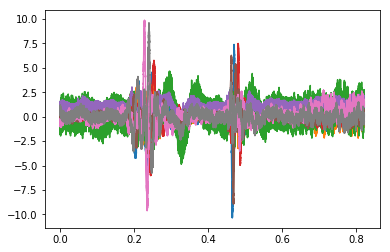

In [4]:
A, Y = cjade(X, m=12, max_iter=200)
# print(Y.shape)
# print(A.shape)
#print(.shape)
plt.plot(data['alldata'][0, 0:41095].T,Y[4:12, 0:41095].T)

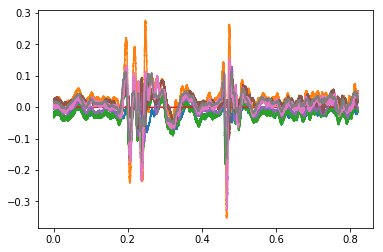

In [5]:
plt.plot(data['alldata'][0, 0:41095].T,data['alldata'][4:12, 0:41095].T)

In [6]:
import numpy as np

offset = 0.14


def timeToSample(args):
    """ Converts the time to the exact sample"""
    return (args)*50000

# Constants

# The start of the heart cycle, roughly 0.8 seconds,
# but we are counting from where S1 begins 
time_range = np.arange(offset,16.00, 0.680)
sample_range = timeToSample(time_range)

# Set where S1 and S2 Start
begS1 = time_range +0.03
endS1 = begS1 + 0.1
begS2 = begS1 + 0.27
endS2 = begS2 + 0.06

# Get their appropriate samples
sampleS1_beg = timeToSample(begS1)
sampleS1_end = timeToSample(endS1)
sampleS2_beg = timeToSample(begS2)
sampleS2_end = timeToSample(endS2)

B = list(zip(sampleS1_beg,sampleS1_end))
C = list(zip(sampleS2_beg,sampleS2_end))

S1 = np.empty([len(B),len(X),5000])
S1_recovered = np.empty_like(S1)
S2 = np.empty_like(S1)
S2_recovered = np.empty_like(S1)

new_m = np.empty([len(B),len(X),5000])
result_array = np.empty([len(X),5000])
# the default dtype is float, so set dtype if it isn't float
#result_array = np.empty([13,5000])
import scipy.io as sio
for i in range(len(B)): # 24 cycles (0.680 seconds)
    for j in range(len(X)+1): # 13 time + all mics
        result_array[j] = data['alldata'][j,int(B[i][0])-1:int(B[i][1])-1]
        #result_array = np.asarray(result_array)[:,np.newaxis]
    filename = 'S1_Cycle'+str(i)+'_datatest.mat'
    sio.savemat(filename, {'S1_Cycle'+str(i):result_array})
        
sound_data = []
#for i in range(len(B)): # 24 cycles (0.680 seconds)
for j in range(len(X)+1): # 13 time + all mics
    filename = 'S1_Cycle'+str(0)+'_mic_'+str(j)+'_datatest.mat'
    data = sio.loadmat(filename)
    sound_data.append(data['S1_Cycle'+str(0)])
    print(sound_data)
            # for idx, line in enumerate(data_array):
# result_array[idx] = do_stuff(line)
        
# a = np.append(new_m, ) #
# print(a.shape)
    
#         #print(len(data['alldata'][j, int(B[i][0])-1:int(B[i][1])-1]))
        
#         # This is each array where the size of the array is not equal to 5000
#         a = np.array(Y[j, int(B[i][0])-1:int(B[i][1])-1])[np.array(Y[j, int(B[i][0])-1:int(B[i][1])-1]).size == 4999]
#         print(a.shape)
#         #S2[i,j,:] = data['alldata'][j, int(C[i][0])-1:int(C[i][1])-1]
        
        #S1_recovered[i,j,:] = Y[j, int(B[i][0])-1:int(B[i][1])-1]
        #S2_recovered[i,j,:] = Y[:, int(C[i][0])-1:int(C[i][1])-1]
# for i in range(len(B)):
#     S1[i,:] = data['alldata'][0, int(B[i][0])-1:int(B[i][1])-1]
#     S1_recovered[i,:] = Y[:, int(B[i][0])-1:int(B[i][1])-1]
# for i in range(len(C)):     
#     S2[i,:] = data['alldata'][0, int(C[i][0])-1:int(C[i][1])-1] 
#     S2_recovered[i,:] = Y[:, int(C[i][0])-1:int(C[i][1])-1]

# for i in range(len(B)):
#     print(Y[i, int(B[i][0])-1:int(B[i][1])-1])  # S1[i,:] = 
#S2 = [Y[:, int(C[i][0])-1:int(C[i][1])-1] for i in range(len(C))]

#print(S1)





# for i in range(len(S1)):
#     filename = 'S1_Cycle'+str(i)+'_test.mat'
#     sio.savemat(filename, {'S1_Cycle'+str(i):S1[i]})
    
# for j in range(len(S2)):
#     sio.savemat(filename, {'S2_Cycle'+str(j):S2[j]})

#
# beginS1 = (0.17-begTime)/rangeTime
# endS1 = (0.28-begTime)/rangeTime

# R1 = rangeSamp * beginS1 + begSamp
# R2 = rangeSamp * endS1 + begSamp
# R2

# #0.8363-0.17
# c =  1.544-0.8363; c

[[0.16998]
 [0.17   ]
 [0.17002]
 ...
 [0.26992]
 [0.26994]
 [0.26996]]
[[-0.0187686 ]
 [-0.01998932]
 [-0.0187686 ]
 ...
 [ 0.00045777]
 [ 0.00015259]
 [-0.00045777]]
[[0.01724269]
 [0.01724269]
 [0.01815824]
 ...
 [0.01480125]
 [0.01907378]
 [0.02059968]]
[[-0.02456703]
 [-0.02792401]
 [-0.02914473]
 ...
 [-0.02914473]
 [-0.03219654]
 [-0.03006027]]
[[-0.01815824]
 [-0.01968414]
 [-0.01785306]
 ...
 [-0.02395666]
 [-0.02426184]
 [-0.02487221]]
[[0.02304112]
 [0.02212558]
 [0.02059968]
 ...
 [0.07125963]
 [0.07522698]
 [0.0764477 ]]
[[-0.03463798]
 [-0.03219654]
 [-0.02944991]
 ...
 [ 0.04470893]
 [ 0.03982605]
 [ 0.03341726]]
[[-0.00076295]
 [-0.00076295]
 [-0.00076295]
 ...
 [-0.00045777]
 [-0.00076295]
 [-0.00076295]]
[[-0.02365148]
 [-0.02487221]
 [-0.02426184]
 ...
 [ 0.03707942]
 [ 0.0373846 ]
 [ 0.03799496]]
[[ 0.00015259]
 [-0.00137331]
 [-0.00350958]
 ...
 [ 0.04776074]
 [ 0.05203326]
 [ 0.05355917]]
[[-0.00137331]
 [ 0.00106813]
 [ 0.00350958]
 ...
 [ 0.05508507]
 [ 0.048981

## References

[Saving and loading Python dict with savemat results in error
](https://stackoverflow.com/questions/9232751/saving-and-loading-python-dict-with-savemat-results-in-error)

[Optimal Way to Append to Numpy Array ](https://stackoverflow.com/questions/25649788/optimal-way-to-append-to-numpy-array?noredirect=1&lq=1)

[Matrix From Python to Matlab](https://stackoverflow.com/questions/1095265/matrix-from-python-to-matlab)

In [7]:
a = 24*12*5035
a

1450080

In [8]:
data = sio.loadmat('S1_Cycle6_test.mat')
data

{'__header__': b'MATLAB 5.0 MAT-file Platform: posix, Created on: Fri Apr 19 19:38:09 2019',
 '__version__': '1.0',
 '__globals__': [],
 'S1_Cycle6': array([[0.1356527]])}

In [9]:
# ica = FastICA(n_components=12)
# S_ = ica.fit_transform(X)  # Reconstruct signals
# A_ = ica.mixing_  # Get estimated mixing matrix
# S_.shape

In [10]:
# # For comparison, compute PCA
# pca = PCA(n_components=4)
# H = pca.fit_transform(X)  # Reconstruct signals based on orthogonal components

In [11]:
# plt.figure()

# plt.plot(Y)

# #plt.plot(S_)





# # models = [X, S_] #, H]
# # names = ['Observations (mixed signal)',
# #          'ICA recovered signals']
# # #          'PCA recovered signals']
# # colors = ['red', 'steelblue', 'orange', 'green', 'blue', 'brown', 'black']

# # for ii, (model, name) in enumerate(zip(models, names), 1):
# #     plt.subplot(4, 1, ii)
# #     plt.title(name)
# #     for sig, color in zip(model.T, colors):
# #         plt.plot(sig, color=color)

# # plt.subplots_adjust(0.09, 0.04, 0.94, 0.94, 0.26, 0.46)
# plt.show()

In [12]:
#plt.plot(H)

In [13]:
p = 0.8219 - 0.14
p2 = 1.501 - 0.8219
p3 = 2.162 - 1.501
p4 = 2.812 - 2.162
total = p + p2+ p3 + p4
avg = total/4
print(avg)
print(p, p2, p3, p4)

0.6679999999999999
0.6819 0.6790999999999999 0.661 0.6499999999999999


## WHAT I NEED TO DO:

1) Start the cycle. Every period of ~0.668 seconds is Period of one cycle (DONE)

2) Find the dilation constant --> we want to JUST isolate S1 and S2 (DONE)

3) Save each for one for told period of ___ of 16 seconds 

4) Write it to folder with a csv file inside? (DONE)

5) Change how we read in the data on the otherside?



In [14]:
r = 0.8219 - 0.14
x1 = 100 * ((0.17- 0.14)/r)
x2 = 100 * ((0.28- 0.14)/r)
print(x1, x2)

4.399472063352397 20.53086962897786
